This is the general code we used and some appropriate adaptation have been made across the four datasets: in particular a slight different preprocessing and also Student Depression and Adult Income needed a different treatment when we estimated the feature importance as they have categorical entries. The analysis has been performed for the 4 datasets and data has been saved.

### 1) Importing Libraries



In [ ]:
!pip install dice_ml
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.4 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.11.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [ ]:
# base libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import os
import random

# dice libraries
import dice_ml
from dice_ml.utils import helpers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2) Importing dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/BSC/Ideas_on_counterfactuals/Datasets'
list_of_datasets = os.listdir(dataset_path)
print("The loaded datasets are: ", list_of_datasets)
target_variables = ['income', 'Outcome', 'target', 'status','Depression', 'satisfaction']

The loaded datasets are:  ['adult.csv', 'diabetes.csv', 'heart.csv', 'parkinsons.data', 'Student Depression Dataset.csv', 'Airline.csv']


In [ ]:
# per il breast cancer devo convertire M, B e rimuovere id anche per student depression rimuovere id
# df.drop('id', axis=1, inplace=True)
# df.drop('Unnamed: 32', axis=1, inplace=True)
# df['diagnosis'] = df['diagnosis'].replace(to_replace='M', value = 1)
# df['diagnosis'] = df['diagnosis'].replace(to_replace='B', value = 0)

def general_processing(dataset, target_variable, imputer=False): # simple processing and extraction of numerical features

    if 'id' in dataset.columns: # we do not want id
        dataset.drop('id', axis=1, inplace=True)

    # Drop rows with missing values
    if dataset.isnull().sum().any():
      if imputer:
          imputer_model = SimpleImputer(strategy='mean')
          dataset.iloc[:, :] = imputer_model.fit_transform(dataset)
      else:
          dataset = dataset.dropna(how="any", axis=0)
    dataset = dataset.rename(columns={target_variable: 'target'})
    columns = [col for col in dataset.columns if col != 'target'] + ['target']     # we move the target column at the end
    dataset = dataset[columns]
    numerical_features = dataset.select_dtypes(include=['number']).columns.tolist()
    numerical_features.remove('target')
    return dataset, numerical_features

# Maybe we should exclude columns where the range of values is very small --> sensitive for counterfactuals

### 3) Dataset Splitting

In [ ]:
from sklearn.model_selection import train_test_split

def dataset_splitting(dataset):
    target = dataset["target"]
    train_dataset, test_dataset, y_train, y_test = train_test_split(dataset,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                stratify=target)
    x_train = train_dataset.drop('target', axis=1)
    x_test = test_dataset.drop('target', axis=1)
    return x_train, x_test, y_train, y_test, train_dataset

### 4) DiCE preparation and pipeline

In [ ]:
# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
list_of_models = [RandomForestClassifier, KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression]

def pipeline(train_dataset, numerical_features):

    # selecting the model
    selected_model = random.choice(list_of_models)

    categorical_features =  train_dataset.columns.difference(numerical_features + ['target'])

    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


    numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

    transformations = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Pipeline
    clf = Pipeline(steps=[
    ('preprocessor', transformations),
    ('classifier', selected_model())
    ])

    # fitting the model
    x_train = train_dataset[list(train_dataset.columns[:-1])]
    y_train = train_dataset["target"]
    model = clf.fit(x_train, y_train)

    return model

def create_dice_dataset(dataset,train_dataset,model):

    d = dice_ml.Data(dataframe=train_dataset, continuous_features=numerical_features, outcome_name='target')
    m = dice_ml.Model(model=model, backend="sklearn")
    exp = dice_ml.Dice(d, m, method="random")
    return exp


### 5) Generating counterfactuals

In [ ]:
# We set x_test[0:1] as the feature to be explained

def cfs_generation(exp,x_test, numerical_features, num=50):

    positive_cfs = exp.generate_counterfactuals(x_test[0:1], total_CFs=num, desired_class="opposite")
    negative_cfs = exp.generate_counterfactuals(x_test[0:1], total_CFs=num, desired_class=0)
    positive_cfs_data = positive_cfs.cf_examples_list[0].final_cfs_df[numerical_features].values
    negative_cfs_data = negative_cfs.cf_examples_list[0].final_cfs_df[numerical_features].values

    return positive_cfs_data, negative_cfs_data

### 6) Dissimilarity Measure and KDE Plots

In [ ]:
from scipy.stats import gaussian_kde

def dissimilarity_kde(data1, data2):
    if np.allclose(data1, data1[0]) or np.allclose(data2, data2[0]): # if no variability then we set 0, KDE cannot be computed
        return 0.0
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)
    x_min = min(data1.min(), data2.min())
    x_max = max(data1.max(), data2.max())
    x = np.linspace(x_min, x_max, 1000)
    density1 = kde1(x)
    density2 = kde2(x)

    dissimilarity = 1 - np.trapz(np.minimum(density1, density2), x) / np.trapz(np.maximum(density1, density2), x)
    return dissimilarity

def plot_kde(data1, data2, col_name):
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)
    x_min = min(data1.min(), data2.min())
    x_max = max(data1.max(), data2.max())
    x = np.linspace(x_min, x_max, 1000)
    density1 = kde1(x)
    density2 = kde2(x)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(x, density1, label="Positive Counterfactuals", color="blue")
    plt.plot(x, density2, label="Negative Counterfactuals", color="orange")
    plt.fill_between(x, np.minimum(density1, density2), color="gray", alpha=0.3, label="Overlap Area")
    # plt.title(f"KDE Comparison for {col_name}")
    # plt.xlabel(col_name)
    # plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


### Results and Feature Importance

In [ ]:
# Preprocessing per airline
# -------------------------------------------------------------------------------------------
dataset.drop(['id','Unnamed: 0'],axis=1, inplace=True)
dataset = dataset.dropna(how="any", axis=0)
dataset['satisfaction'] = dataset['satisfaction'].replace(to_replace='satisfied', value = 1)
dataset['satisfaction'] = dataset['satisfaction'].replace(to_replace='neutral or dissatisfied', value = 0)
dataset = dataset.rename(columns={target_variable: 'target'})
numerical_features = dataset.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('target')
# -------------------------------------------------------------------------------------------

In [ ]:
import shap
from sklearn.inspection import permutation_importance

dataset = list_of_datasets[4]
target_variable = target_variables[4]
dataset, numerical_features = general_processing(pd.read_csv(os.path.join(dataset_path,dataset)), target_variable)
x_train, x_test, y_train, y_test, train_dataset = dataset_splitting(dataset)
model = pipeline(train_dataset,numerical_features)
exp = create_dice_dataset(dataset,train_dataset,model)

dissimilarity_results = {col: [] for col in numerical_features}
importance_results = {col: [] for col in numerical_features}

iterations = 100

for i in range(iterations):
    query_instance = x_test[0:1]
    imp = exp.local_feature_importance(query_instance, total_CFs=50)
    positive_cfs_data, negative_cfs_data = cfs_generation(exp,x_test, numerical_features)

    for i, col in enumerate(numerical_features):
        data1 = positive_cfs_data[:, i]
        data2 = negative_cfs_data[:, i]
        diss = dissimilarity_kde(data1, data2)
        dissimilarity_results[col].append(diss)


    for col in numerical_features:
        importance_results[col].append(imp.local_importance[0][col])

# Results
dissimilarity_df = pd.DataFrame(dissimilarity_results)
importance_df = pd.DataFrame(importance_results)


100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=x_train.values,
    mode="classification",
    feature_names=x_train.columns,
)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
explainer = LimeTabularExplainer(
    training_data=model.named_steps['preprocessor'].transform(x_train),
    mode="classification",
    feature_names=x_train.columns,
    discretize_continuous=True
)

In [ ]:
# Extract feature importances in the order for LIME
importances_lime = [-0.032082043897764666, -0.26709411778151443, -0.2585880199064319, 0.09977035016953352, -0.016387644550994146, 0.01655133235113405, -0.05468159586974136, -0.12699374550639408, -0.17391994865336077, -0.2105744671273198, -0.12597968355561245, -0.041630491377675057, 0.1671510134038858]



In [ ]:
numerical_features

['Age',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Work/Study Hours',
 'Financial Stress']

In [ ]:
import shap
from sklearn.inspection import permutation_importance

# Getting feature importances: SHAP, pearsonr, permutation test

selected_model = model.named_steps['classifier']

if isinstance(selected_model, RandomForestClassifier):
    explainer = shap.TreeExplainer(selected_model)
elif isinstance(selected_model, DecisionTreeClassifier):
    explainer = shap.TreeExplainer(selected_model)
elif isinstance(selected_model, LogisticRegression):
    explainer = shap.LinearExplainer(selected_model,  x_train)
else:
    explainer = shap.KernelExplainer(selected_model.predict_proba, x_train)

# Computation of shap values
# shap_values = explainer.shap_values(x_test[0:1])

shap_values = explainer.shap_values(x_test[0:1])
correlation_matrix = dataset[numerical_features + ['target']].corr()
target_correlation = correlation_matrix['target'][:-1]


perm_importance = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42)
perm_importance_scores = perm_importance.importances_mean

# we have to filter to get only those variable
perm_importance_array = [perm_importance_scores[dataset.columns.get_loc(feature)] for feature in numerical_features]


ValueError: could not convert string to float: 'Male'

In [ ]:
shap_values_numerical=[]

for feature in numerical_features:
    idx = dataset.columns.get_loc(feature)
    shap_values_numerical.append(float(shap_values[0][idx][0]))

In [ ]:
# Result visualization

results_df = pd.DataFrame({
    'Feature': numerical_features,
    'Dissimilarity': dissimilarity_df.mean(axis=0).values,
    'DiCE Importance': importance_df.mean(axis=0).values,
    'SHAP Importance': shap_values[0],
    'LIME Importance': importances_lime,
    'Pearson Correlation': target_correlation.values,
    'Permutation Importance': perm_importance_array
})

print("We are using the dataset: ", list_of_datasets[4])
print("\n")
results_df

We are using the dataset:  heart.csv




,Feature,Dissimilarity,DiCE Importance,SHAP Importance,LIME Importance,Pearson Correlation,Permutation Importance
0,age,0.310265,0.2426,-1.074923,-0.032082,-0.229324,-0.007805
1,sex,0.714655,0.5612,-0.242341,-0.267094,-0.279501,0.035610
2,cp,0.822264,0.7934,-0.772315,-0.258588,0.434854,0.023415
3,trestbps,0.512483,0.1358,3.917459,0.099770,-0.138772,-0.020488
4,chol,0.462853,0.1566,-0.907916,-0.016388,-0.099966,-0.010244
5,fbs,0.318435,0.1170,0.001464,0.016551,-0.041164,0.000000
6,restecg,0.551675,0.2612,-0.089746,-0.054682,0.134468,-0.004390
7,thalach,0.582921,0.5166,-22.026003,-0.126994,0.422895,-0.010244
8,exang,0.604392,0.3464,-0.336086,-0.173920,-0.438029,-0.018049
9,oldpeak,0.350887,0.2156,-0.794898,-0.210574,-0.438441,0.016098


In [ ]:
from google.colab import files

results_df.to_csv('results_heart.csv', index=False)
files.download('results_heart.csv')
dissimilarity_df.to_pickle('dissimilarity_heart.pkl')
importance_df.to_pickle('importance_heart.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('dissimilarity_heart.pkl')
files.download('importance_heart.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Boxplot

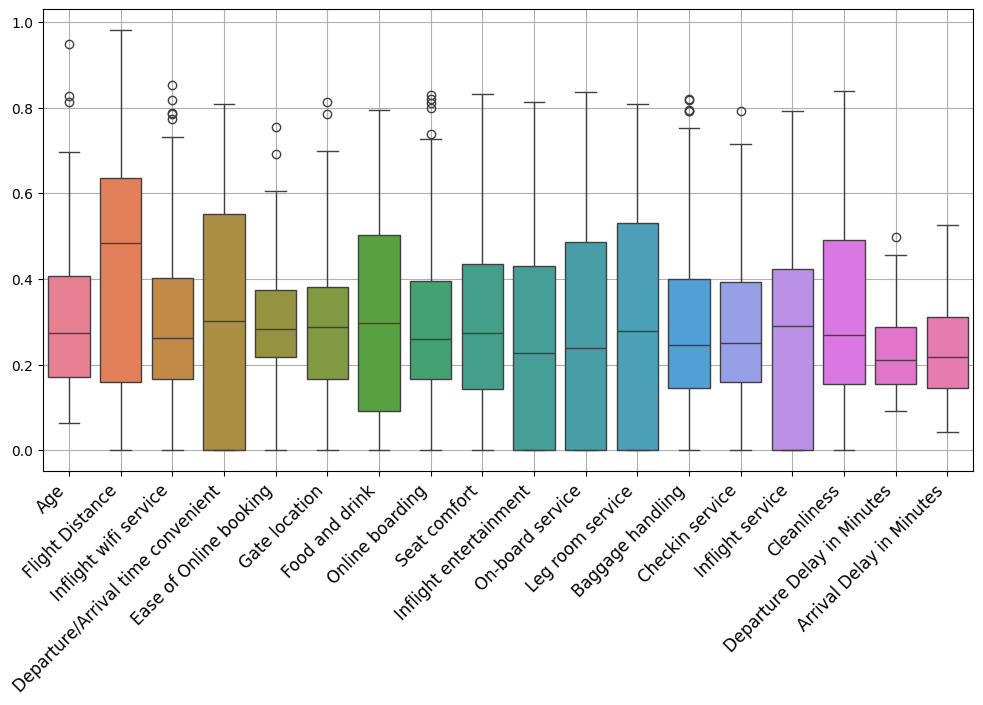

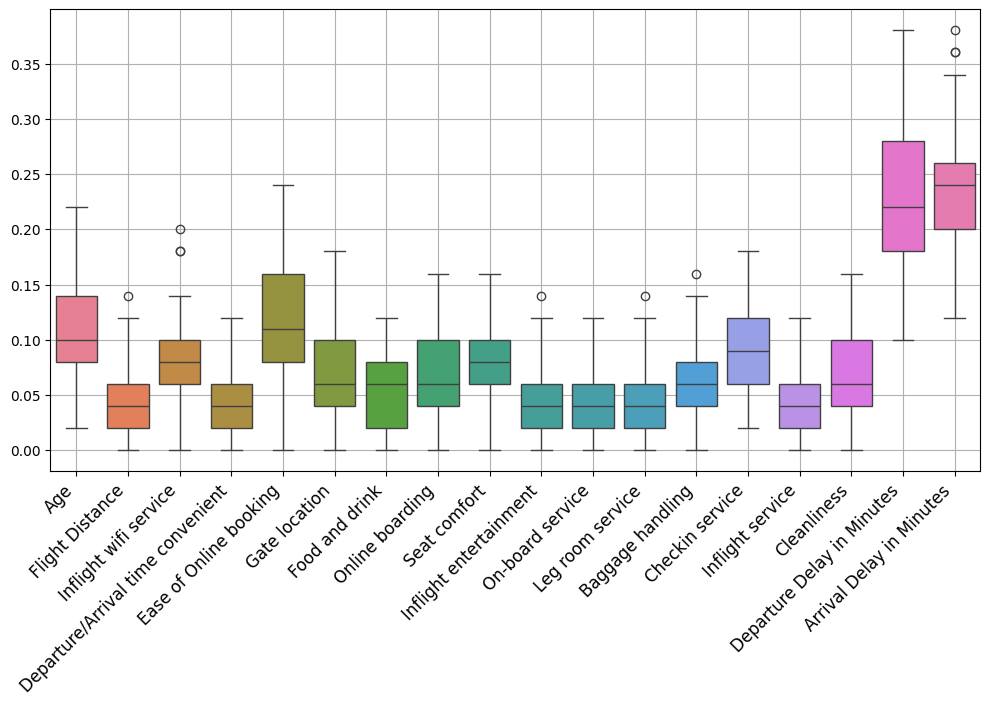

In [ ]:
# boxplot for d_k(p,q)
plt.figure(figsize=(12, 6))
sns.boxplot(data=dissimilarity_df)
# plt.title("Dissimilarity Distribution Across 100 Iterations")
# plt.ylabel("Dissimilarity")
# plt.xlabel("Features")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True)
plt.show()

# boxplot for dice importance
plt.figure(figsize=(12, 6))
sns.boxplot(data=importance_df)
# plt.title("Feature Importance Distribution Across 100 Iterations")
# plt.ylabel("Importance")
# plt.xlabel("Features")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True)
plt.show()

### Violin plots

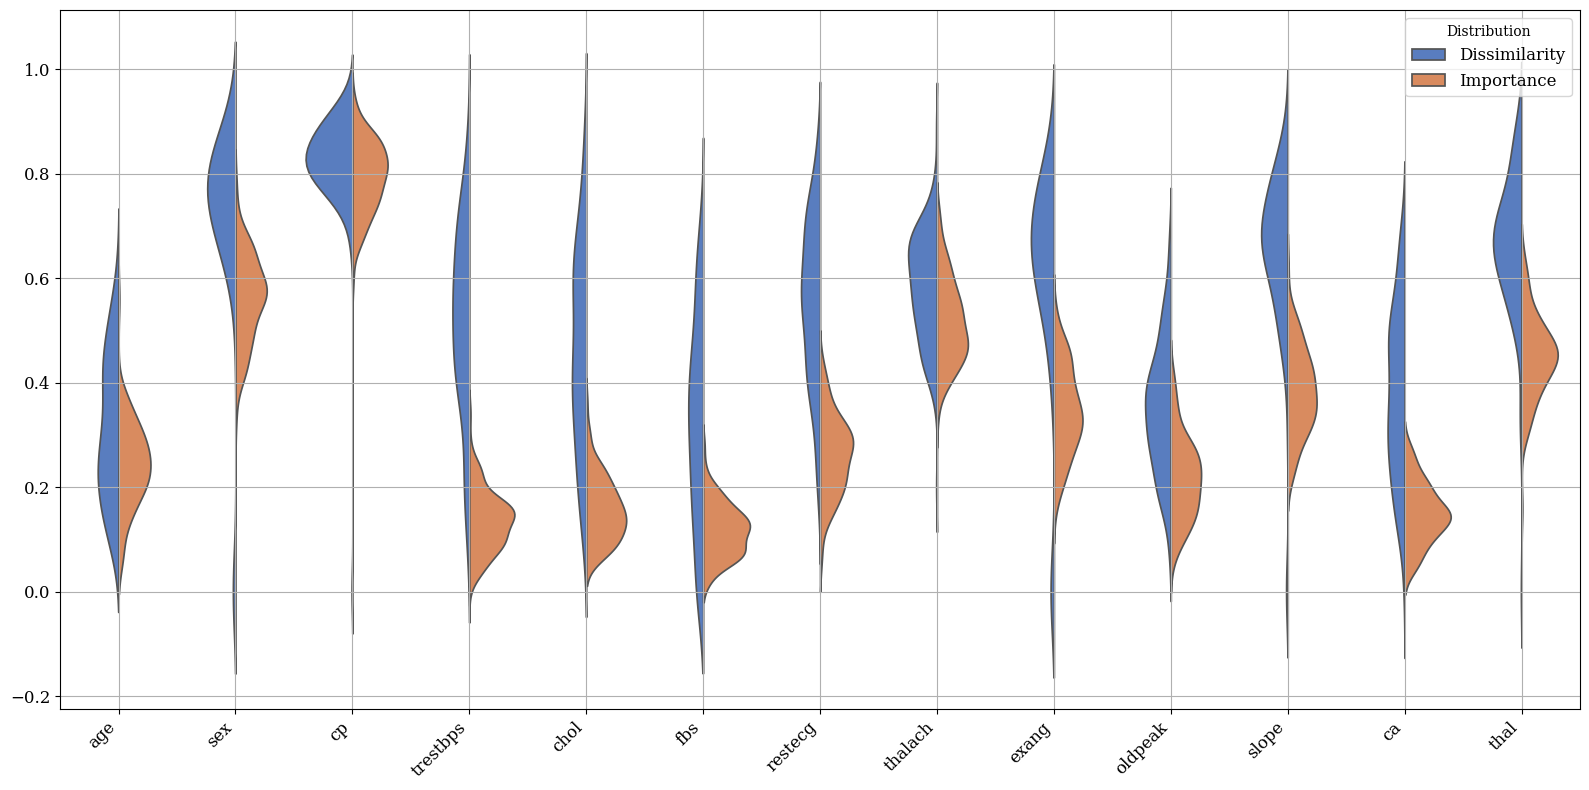

In [ ]:
dissimilarity_df = dissimilarity_df.apply(pd.to_numeric, errors='coerce')
importance_df = importance_df.apply(pd.to_numeric, errors='coerce')
dissimilarity_long = dissimilarity_df.melt(var_name='Features', value_name='Value')
dissimilarity_long['Distribution'] = 'Dissimilarity'
importance_long = importance_df.melt(var_name='Features', value_name='Value')
importance_long['Distribution'] = 'Importance'
combined_df = pd.concat([dissimilarity_long, importance_long], ignore_index=True)
plt.figure(figsize=(16, 8))
sns.set_palette("muted")
sns.violinplot(data=combined_df, x='Features', y='Value', hue='Distribution', split=True, inner=None)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.grid(True)
plt.tight_layout()
plt.show()